In [2]:
%matplotlib inline
# https://scipy.github.io/devdocs/reference/spatial.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree.query_radius

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from PIL import Image
from scipy.spatial import distance
from operator import itemgetter
from sklearn.neighbors import KDTree
import time
import imageio
import os
import glob

In [3]:
"""

p_00 = {R, G, B} = N
...
p_nm = {R, G, B} =

hacia que lados del circulo buscar

usar un regularizador para optimizar el DBSCAN

p00 = {R, G, B, i, j}


revisar localidad (flood fill algorithm)

pasarlo a blanco y negro y luego probar el algoritmo con escala de grises
"""

'\n\np_00 = {R, G, B} = N\n...\np_nm = {R, G, B} =\n\nhacia que lados del circulo buscar\n\nusar un regularizador para optimizar el DBSCAN\n\np00 = {R, G, B, i, j}\n\n\nrevisar localidad (flood fill algorithm)\n\npasarlo a blanco y negro y luego probar el algoritmo con escala de grises\n'

In [4]:
UNDEFINED = 0
NOISE = 1
EPS = 2
TRESHOLD = 75

In [5]:
class DBScan():
    def __init__(self, data, eps, treshold, m='euclidean'):
        self.data = data        # database
        self.KDT = KDTree(data) 
        self.e = eps            # radius
        self.t = treshold       # minPoints: density treshold

        # cluster of i-th training example
        self.label = np.array([UNDEFINED for _ in range(len(data))])        
    
    def region_query(self, p):
        N = self.KDT.query_radius([p], r=self.e)[0]  
        N = [n for n in N if self.label[n] in [UNDEFINED, NOISE] ]
        return np.array(N, dtype=object)

    def dbs(self):
        c = 1
        for i in range(len(self.data)):
            label_p = self.label[i]         # label of i-th training example
            
            if label_p != UNDEFINED:
                continue
            # get index of nearest neighbors of i-th trainig example
            NN = self.region_query(self.data[i])
            
            if len(NN) < self.t:
                self.label[i] = NOISE
                continue
            
            c += 1
            self.label[i] = c
            
            # S <- N \ {p}
            S = [NN[_] for _ in np.where(NN!=i)[0]]

            for q in S:
                label_curr = self.label[q]
                if label_curr == NOISE:
                    self.label[q] = c
                if label_curr != UNDEFINED:
                    continue
                NE = self.region_query(self.data[q])
                self.label[q] = c
                if len(NE) < self.t:
                    continue
                S += [_ for _ in NE if _ not in S]
        return self.label
        
    def execute(self):
        self.dbs()

In [6]:
IMG_PATH = './mini_data/'

# **SIMULACIÓN**

In [17]:
def preprocesamiento(path):
    img = Image.open(path)

    # resizing
    H, W = img.size
    h, w = img.size
    k = 1

    while h >= 100 or w >= 100:
        k += 1
        h = H/k
        w = W/k

    img = img.resize((int(h), int(w))) #.convert('1')
    # display(img)
    mat = np.asarray(img).astype(int)
    return mat

0.jpg
clusters 7
1.jpg
clusters 7
10.jpg
clusters 5
100.jpg
clusters 4
101.jpg
clusters 5


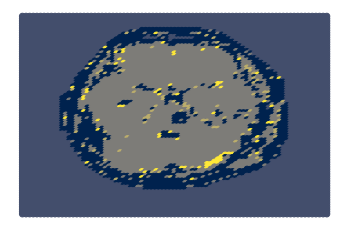

In [18]:
for name in os.listdir(IMG_PATH):
    # read and resize image
    print(name)
    # img = Image.open(IMG_PATH + name)
    # w, h = img.__dict__['_size']
    mat = preprocesamiento(IMG_PATH+name) # np.asarray(img.resize((int(w/4), int(h/4))))
    
    M = []
    for i in range(len(mat)):
        for j in range(len(mat[i])):
            pixel = mat[i, j]
            M.append(np.array(list(pixel) + [i, j], dtype=object))
    M = np.array(M)
    pixels_db = M[: , 0:3]

    dbscan = DBScan(pixels_db, EPS, TRESHOLD)
    result = dbscan.dbs()

    print(f'clusters {len(np.unique(result))}')

    ij_cluster = pd.DataFrame()
    ij_cluster['i'] = M[: , -2]
    ij_cluster['j'] = M[: , -1]
    ij_cluster['clusters'] = result
    file_name = name.replace('.jpg', '')
    ij_cluster.to_csv(f'./Resultados/DBScan/{file_name}_dbs.csv')

    X = ij_cluster['j'].tolist()
    Y = ij_cluster['i'].tolist()
    plt.clf()
    plt.scatter(X,Y,c=ij_cluster['clusters'].tolist(), cmap='cividis')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.savefig(f'./Resultados/DBScan/{file_name}_dbs.png', dpi=1200)

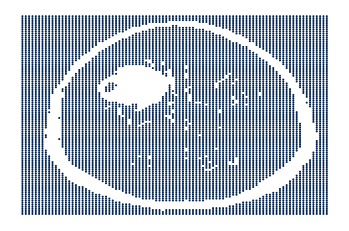

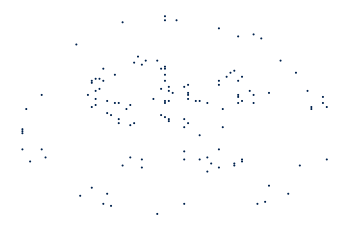

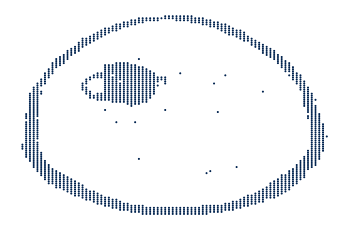

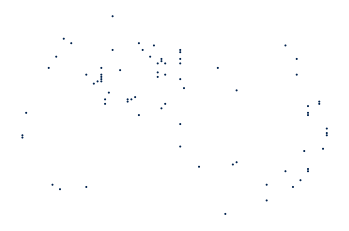

In [ ]:
# for _ in list(ij_cluster['clusters'].unique()):
#     current = ij_cluster[ij_cluster['clusters'] == _]
    
#     X = current['j'].tolist()
#     Y = current['i'].tolist()

#     fig = plt.figure()
#     plt.scatter(X, Y, c=current['clusters'].tolist(), cmap='cividis', s=1)
#     plt.axis('off')
#     plt.gca().invert_yaxis()

# **Layer analysis**

In [ ]:
# df = pd.read_csv('./Resultados/DBScan/0.csv', index_col='Unnamed: 0')

In [ ]:
# X = df['j'].tolist()
# Y = df['i'].tolist()

# fig = plt.figure()
# plt.scatter(X, Y, c=df['clusters'].tolist(), cmap='cividis', s=1)
# plt.axis('off')
# plt.gca().invert_yaxis()

NameError: name 'df' is not defined

In [ ]:
# freq = df['clusters'].value_counts()
# # freq[freq > 100]
# print(freq.to_dict())
# # freq.index
# # freq[freq > 100].index.to_list()
# top = freq[freq > 1000].index.to_list()
# print(top)
# points = df[df['clusters'].isin(top)]

In [ ]:
for _ in list(df['clusters'].unique()):
    current = df[df['clusters'] == _]
    
    X = current['j'].tolist()
    Y = current['i'].tolist()

    fig = plt.figure()
    plt.scatter(X, Y, c=current['clusters'].tolist(), cmap='cividis', s=1)
    plt.axis('off')
    plt.gca().invert_yaxis()